# Limit order book (LOB) simulation

Using [Bouchaud et al. (2018)](https://doi.org/10.1017/9781316659335) as the main reference here.

Also look at [Blanc, Donier & Bouchaud (2015)](https://doi.org/10.1080/14697688.2016.1193215) for the right Hawkes process ideas.

The simulation of financial markets through the use of agent-based models is an increasingly popular technique to understand the microstructure of their dynamics from the bottom up. In this notebook, we'll look at an example market simulation.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get the class structures
import sys
sys.path.append("/Users/Rob/work/finmarbs/utils/")
from lobsim import LOBsim
from sfagent import SFagentens

Begin with a **heterogeneous individual-agent** version of the original **Santa Fe model** using a synchronous ensemble rejection algorithm. The key point here is to make sure the overall holding rate is large enough which should limit the number of anachronisms in the order flow...

In [2]:
setup = {
    # Number of agents
    "Nagents" : 100,
    # 1/variance in agent relative trading rates
    "heterok" : 0.5,
    # Mean global agent speculation rate
    "meanspecrate" : 1.0,
    # Mean limit order rate per agent on the bid side
    "meanLOratebid" : 1.5,
    # Mean limit order rate per agent on the ask side
    "meanLOrateask" : 1.5,
    # Mean market order rate per agent on the bid side
    "meanMOratebid" : 0.3,
    # Mean market order rate per agent on the ask side
    "meanMOrateask" : 0.3,
    # Mean cancel order rate per agent on the bid side
    "meanCOratebid" : 0.1,
    # Mean cancel order rate per agent on the ask side
    "meanCOrateask" : 0.1,
    # The overall mean holding rate
    "meanHOrate" : 100.0,
    # Limit order decay power in price units
    "LOdecay" : 0.1,
    # Initial bid tick
    "initbidpricetick" : 100,
    # Initial ask tick
    "initaskpricetick" : 101,
    # The price tick size
    "tickscale" : 1.0,
    # The number of price points simulated
    "Nlattice" : 200,
    # Hawkes kernel power for endogeneous excitations
    "Hawkespow" : 0.8,
    # Trader behaviour ratio between endogeneous vs exogeneous
    "rbehaviours" : np.random.uniform(size=100),
}

# Initialise the LOB simulation
los = LOBsim(setup, agentens=SFagentens)

# Iterate the LOB over time
tend, t = 100.0, 0.0
midps = []
while t < tend:
    los.iterate()
    t = los.time
    midps.append([t, los.market_state_info["midprice"]])

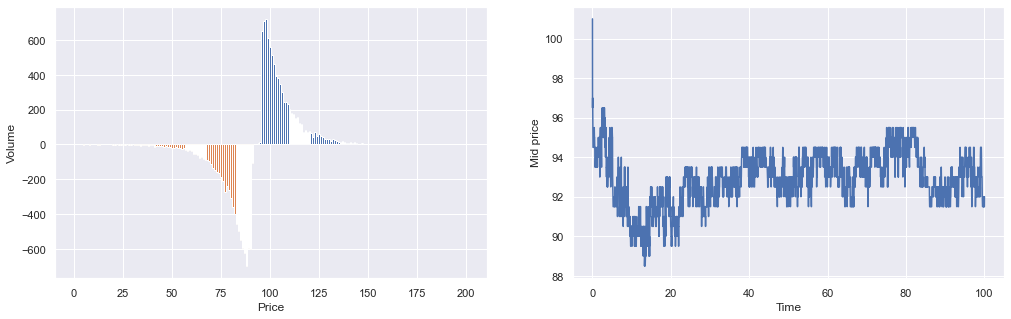

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].bar(los.prices, los.asks)
ax[0].bar(los.prices, -los.bids)
ax[1].plot(np.asarray(midps)[:, 0], np.asarray(midps)[:, 1])
ax[0].set_ylabel('Volume')
ax[0].set_xlabel('Price')
ax[1].set_ylabel('Mid price')
ax[1].set_xlabel('Time')
plt.show()

The master equation for the process above at price $p$ is

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t) &= \sum_{\forall i}\gamma_{ib}(t)\lambda^p_b(t) P(\dots, V^p_{ib}-1, \dots, V^p_{ia}, \dots, t) \\
&+ \sum_{\forall i}\gamma_{ia}(t)\lambda^p_a(t) P(\dots, V^p_{ib}, \dots, V^p_{ia}-1, \dots, t) \\
&+ \sum_{\forall i}\frac{(V^p_{ib}+1)\sum_{\forall i'}\mu^p_{i'b}(t)}{1+\sum_{\forall i'}V^p_{i'b}} P(\dots, V^p_{ib}+1, \dots, V^p_{ia}, \dots, t) \\
&+ \sum_{\forall i}\frac{(V^p_{ia}+1)\sum_{\forall i'}\mu^p_{i'a}(t)}{1+\sum_{\forall i'}V^p_{i'a}} P(\dots, V^p_{ib}, \dots, V^p_{ia}+1, \dots, t) \\
&+ \sum_{\forall i}(V^p_{ib}+1)\nu_b P(\dots, V^p_{ib}+1, \dots, V^p_{ia}, \dots, t) \\
&+ \sum_{\forall i}(V^p_{ia}+1)\nu_a P(\dots, V^p_{ib}, \dots, V^p_{ia}+1, \dots, t) \\
&- \sum_{\forall i}
\bigg\{ \gamma_{ib}(t)\lambda^p_b(t) + \gamma_{ia}(t)\lambda^p_a(t) + \mu^p_{ib}(t) + \mu^p_{ia}(t) + V^p_{ib}\nu_b + V^p_{ia}\nu_a \bigg\} P(\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t)\,,
\end{align}
$$

where $m(t)=[b(t)+a(t)]/2$ is the mid price and the other functions are

$$
\begin{equation}
\lambda^p_b(t) = \lambda_b \mathbb{1}_{m(t)\geq p} e^{-\alpha [m(t)-p]}\,, \quad \lambda^p_a(t) = \lambda_a \mathbb{1}_{p\geq m(t)} e^{-\alpha [p-m(t)]}\,, \quad \mu^p_{ib}(t) = \mu_{ib}(t) \mathbb{1}_{a(t)= p}\,, \quad \mu^p_{ia}(t) = \mu_{ia}(t) \mathbb{1}_{b(t)= p} \,,
\end{equation}
$$

where: $\lambda_b\,, \lambda_a$ are the average limit order rates per agent; $\alpha$ is the limit order decay power; $\mu_b(t)\,, \mu_a(t)$ are the average market order rates per agent; $\nu_b\,, \nu_a$ are the average order-cancellation rates per agent; and $\gamma_{ib}(t), \gamma_{ia}(t)$ model the $i$-th agents' preferred relative trading rates, which we draw in each case from a unit-mean and $1/k$-variance gamma distribution, i.e., ${\rm PDF}(\gamma_{ia})={\rm Gamma}(\gamma_{ia};k,k)$ and refresh for each agent at a constant speculation rate of $s$. Note that we denote $\mathbb{1}_A$ as an indicator function which takes value unity when $A$ is true, else 0.

In the above model, we've chosen to model exogeneously-driven price movements through limit order flow imbalances via each agents' preferred relative trading rates, which are themselves stochastically updated in time. In contrast, the endogeneous self-excitations are modelled by Hawkes process kernels for the market order rates

$$
\begin{align}
\mu_{ib}(t) &= r_i\mu_{b} - (1-r_i)\sum_{\forall i'}\int^{t}_{t_0}{\rm d}V^{a}_{i'b}(t')\Phi (t-t') \\
\mu_{ia}(t) &= r_i\mu_{a} - (1-r_i)\sum_{\forall i'}\int^{t}_{t_0}{\rm d}V^{b}_{i'a}(t')\Phi (t-t') \,,
\end{align}
$$

where $r_i\in [0, 1]$ is a ratio which governs each agents' individual level of reactionary behaviour.

In the limit where $r_i=1$ for all agents, let us now approximate the volume sums to be the time-dependent stochastic processes $F^p_{a}(t) \simeq \sum_{\forall i'}V^p_{i'a}(t)$ and $F^p_{b}(t) \simeq \sum_{\forall i'}V^p_{i'b}(t)$ which are uncorrelated to the $i$-th agent's actions. By then marginalising over the full master equation bid and ask volumes $\forall i'\neq i$, we can hence obtain an approximate equation for each individual agent

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(V^p_{ib}, V^p_{ia}, t) &\simeq \gamma_{ib}(t)\lambda^p_b(t) P(V^p_{ib}-1, V^p_{ia}, t) + \gamma_{ia}(t)\lambda^p_a(t) P(V^p_{ib}, V^p_{ia}-1, t) \\
&+ \frac{(V^p_{ib}+1)}{1 + F^p_{b}(t)}\sum_{\forall i'}\mu^p_{i'b}(t)P(V^p_{ib}+1, V^p_{ia}, t) + \frac{(V^p_{ia}+1)}{1+F^p_{a}(t)}\sum_{\forall i'}\mu^p_{i'a}(t)P(V^p_{ib}, V^p_{ia}+1, t) \\
&+ (V^p_{ib}+1)\nu_b P(V^p_{ib}+1, V^p_{ia}, t) + (V^p_{ia}+1)\nu_a P(V^p_{ib}, V^p_{ia}+1, t) \\
&- \bigg\{ \gamma_{ib}(t)\lambda^p_b(t) + \gamma_{ia}(t)\lambda^p_a(t) + \frac{V^p_{ib}}{F^p_{b}(t)}\sum_{\forall i'}\mu^p_{i'b}(t) + \frac{V^p_{ia}}{F^p_{a}(t)}\sum_{\forall i'}\mu^p_{i'a}(t) + V^p_{ib}\nu_b + V^p_{ia}\nu_a \bigg\} P(V^p_{ib}, V^p_{ia}, t)\,.
\end{align}
$$

Taking the first moments of this equation with respect to $V^p_{ia}$ and $V^p_{ib}$ in turn, we then obtain the probability mass function solution of two independent time-inhomogeneous Poisson processes

$$
\begin{align}
P(V^p_{ib}, V^p_{ia}, t) &\simeq {\rm Poisson}\big[ V^p_{ib};{\rm E}_{t}(V^p_{ib})\big] {\rm Poisson}\big[ V^p_{ia};{\rm E}_{t}(V^p_{ia})\big] \\
{\rm E}_{t}(V^p_{ib}) &\simeq {\rm E}_{t_0}(V^p_{ib})\exp \bigg\{ - \int_{t_0}^t \frac{\sum_{\forall i'}\mu^p_{i'b}(t')}{F^p_{b}(t')}{\rm d}t' - \nu_b(t-t_0)\bigg\} \\
&+  \int_{t_0}^t {\rm d}t' \gamma_{ib}(t')\lambda^p_b(t') \exp \bigg\{ - \int_{t'}^t \frac{\sum_{\forall i'}\mu^p_{i'b}(t'')}{F^p_{b}(t'')}{\rm d}t'' - \nu_b(t-t')\bigg\} \\
{\rm E}_{t}(V^p_{ia}) &\simeq {\rm E}_{t_0}(V^p_{ia})\exp \bigg\{ - \int_{t_0}^t \frac{\sum_{\forall i'}\mu^p_{i'a}(t')}{F^p_{a}(t')}{\rm d}t' - \nu_a(t-t_0)\bigg\} \\
&+ \int_{t_0}^t {\rm d}t' \gamma_{ia}(t')\lambda^p_a(t') \exp \bigg\{ - \int_{t'}^t \frac{\sum_{\forall i'}\mu^p_{i'a}(t'')}{F^p_{a}(t'')}{\rm d}t'' - \nu_a(t-t')\bigg\} \,.
\end{align}
$$

Note that by summing over $i$, we obtain an approximate description of the volume queue at each price $p$. Furthermore, we may infer that the probabilities for a price having non-zero bid or ask volume, respectively, at time $t$ are given by

$$
\begin{equation}
P(V^p_{b}>0, t) = 1-e^{-\sum_{\forall i}{\rm E}_{t}(V^p_{ib})}\,, \qquad P(V^p_{a}>0, t) = 1-e^{-\sum_{\forall i}{\rm E}_{t}(V^p_{ia})}\,.
\end{equation}
$$

Note also that as the distribution approaches stationarity, the distributions over the sum of agent volumes $\sum_{\forall i}V^p_{ib}$ and $\sum_{\forall i}V^p_{ia}$ for a given price are also approximately Poisson (since there is an overall cancellation of the gamma-distributed factor in the second integrals within the expressions above). 

**Maybe we can also approximate** ${\rm d}F^p_{b}(t) \simeq \big\{ {\rm E}[V^p_{b}(t)] - V^p_{b}(t)\big\} q{\rm d}t + {\rm Var}[V^p_{b}(t)]^{1/2}q^{1/2}{\rm d}W(t)$ where $q$ is some mean-reversion rate to think about.

Analyses to perform:
1. Try to derive a theory for the time evolution of the mid price
2. Extended master equation to account for all of the above effects
3. A large-$N$ expansion and derive some jump-diffusion equations based on temporal scales
4. Bayesian analysis and inference of the market using mock data generated with the simulator using a general model with the above suggestions and either derivatives of the likelihood from the ODE using the multiple-adjoint method or an ABC emulator method
5. Bayesian analysis and inference of the market using mock data generated with the simulator using a geometric Brownian motion model for the mid price only to mimic Black-Scholes risk calibration

## Bayesian agent extensions to the Santa Fe model

In this section we will build cleverer agents in a new class to place within the above market simulation - these are Bayesian agents who treat the market like a geometric Brownian motion and try to infer price movements from this and mock correlated markets. They will also seek to maximise their respective log-returns over time using this inferred knowledge via an dynamic hedging strategy given their internal models.